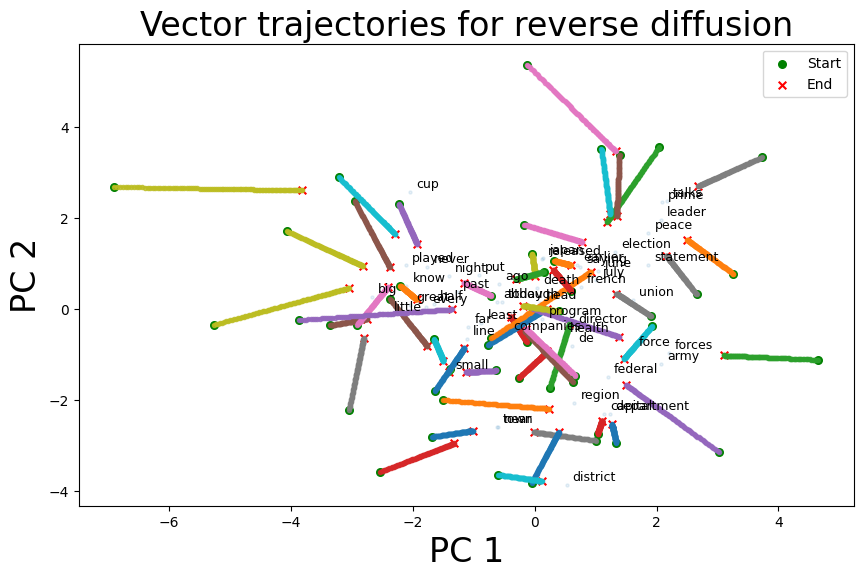

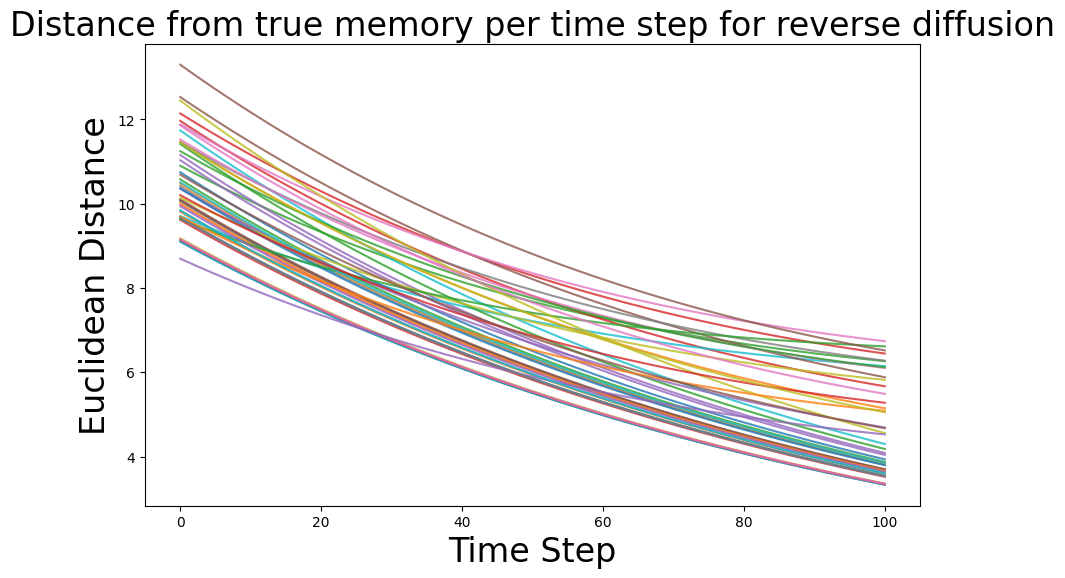

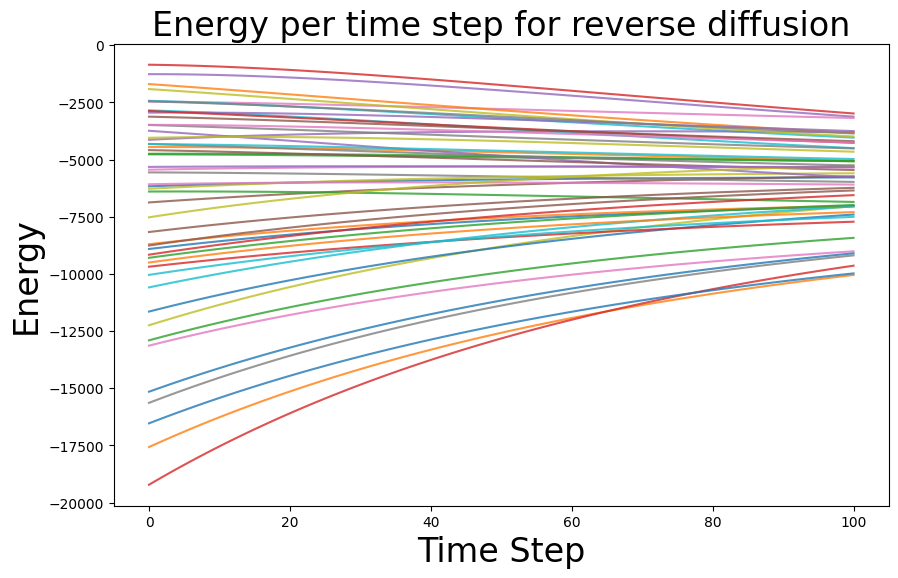

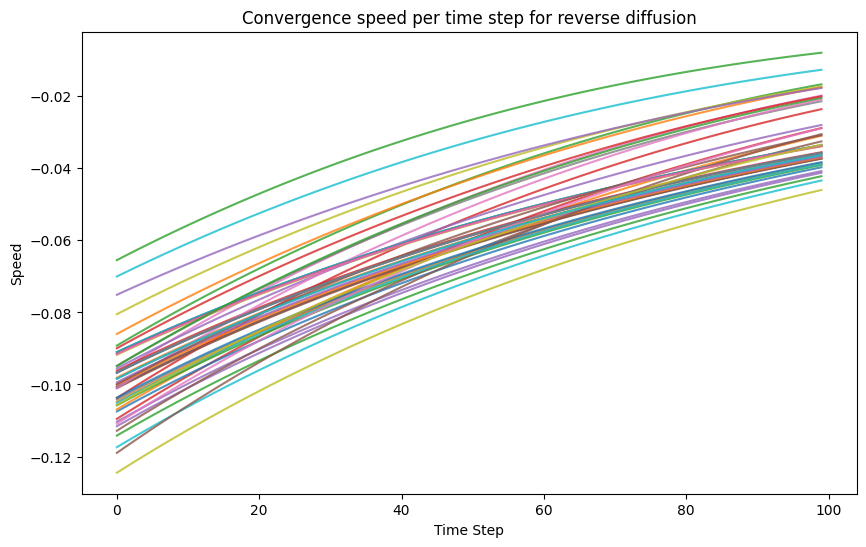


Average success probability over 10 runs: 60.80%


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load GloVe embeddings (first 5000 vectors)
def load_glove_vectors(glove_path, max_vectors=5000):
    embeddings = []
    words = []
    with open(glove_path, 'r', encoding='utf8') as f:
        for i, line in enumerate(f):
            if i >= max_vectors:
                break
            parts = line.strip().split()
            word = parts[0]
            vec = np.array(parts[1:], dtype=np.float32)
            words.append(word)
            embeddings.append(vec)
    embeddings = np.stack(embeddings)
    return words, embeddings

# --- Modified score and reverse diffusion functions ---
def estimate_score(x, memory_vectors, sigma=0.1):
    distances = np.linalg.norm(memory_vectors - x, axis=1)
    closest_idx = np.argmin(distances)
    score = (memory_vectors[closest_idx] - x) / (sigma ** 2)
    return score

def reverse_diffusion_step(x, data, t, dt, bandwidth):
    s = estimate_score(x, data, bandwidth)
    x_new = x + (bandwidth**2) * s * dt
    return x_new
# ------------------------------------------------------

# === Energy function ===
def compute_energy(x, Xi):
    # Energy: E = - (1/2) * x^T Xi^T Xi x
    # Xi^T Xi is like the weight matrix in this modern hopfield setup
    W = Xi.T @ Xi
    return -0.5 * x.T @ W @ x

# Reverse diffusion parameters
T = 1.0          # total diffusion time
N = 100          # number of reverse steps
dt = T / N
sigma_0 = 1.5    # noise scale at time 0

time_steps = np.linspace(T, 0, N)

def sigma(t):
    return sigma_0 * (t / T)

def find_closest_word(x, data, words):
    dists = np.linalg.norm(data - x, axis=1)
    idx = np.argmin(dists)
    return words[idx], dists[idx]

def generate_samples_from_noisy_data(data, words, bandwidth=0.1):
    trajectories = []
    distances = []
    energies = []
    closest_words = []

    for i, original_vec in enumerate(data):
        x = original_vec + np.random.randn(data.shape[1]) * sigma_0
        traj = [x.copy()]
        dist = [np.linalg.norm(x - original_vec)]
        energy = [compute_energy(x, data)]

        for t in time_steps:
            x = reverse_diffusion_step(x, data, t, dt, bandwidth)
            traj.append(x.copy())
            dist.append(np.linalg.norm(x - original_vec))
            energy.append(compute_energy(x, data))

        word, dist_to_word = find_closest_word(x, data, words)
        closest_words.append((word, dist_to_word))

        trajectories.append(np.array(traj))
        distances.append(dist)
        energies.append(energy)

    successes = [1 if closest_words[i][0] == words[i] else 0 for i in range(len(words))]
    success_prob = sum(successes) / len(successes)

    return trajectories, distances, energies, closest_words, success_prob

# Plotting functions
def plot_pca_trajectories(trajectories, data, target_words):
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)
    plt.figure(figsize=(10, 6))
    plt.scatter(data_2d[:,0], data_2d[:,1], s=5, alpha=0.1)
    for i, traj in enumerate(trajectories[:50]):
        traj_2d = pca.transform(traj)
        target_point_2d = data_2d[i]
        plt.plot(traj_2d[:,0], traj_2d[:,1], marker='.', alpha=0.8)
        plt.scatter(traj_2d[0,0], traj_2d[0,1], marker='o', color='green', s=30, label='Start' if i==0 else "")
        plt.scatter(traj_2d[-1,0], traj_2d[-1,1], marker='x', color='red', s=30, label='End' if i==0 else "")
        plt.text(target_point_2d[0]+0.1, target_point_2d[1]+0.1, target_words[i], fontsize=9, color='black')
    plt.legend()
    plt.title('Vector trajectories for reverse diffusion', fontsize=24)
    plt.xlabel('PC 1', fontsize=24)
    plt.ylabel('PC 2', fontsize=24)
    plt.show()

def plot_convergence_distances(distances):
    plt.figure(figsize=(10, 6))
    for dist in distances[:50]:
        plt.plot(dist, alpha=0.8)
    plt.title('Distance from true memory per time step for reverse diffusion', fontsize=24)
    plt.xlabel('Time Step', fontsize=24)
    plt.ylabel('Euclidean Distance', fontsize=24)
    plt.show()

def plot_energy(energies):
    plt.figure(figsize=(10, 6))
    for energy in energies[:50]:
        plt.plot(energy, alpha=0.8)
    plt.title('Energy per time step for reverse diffusion', fontsize=24)
    plt.xlabel('Time Step', fontsize=24)
    plt.ylabel('Energy', fontsize=24)
    plt.show()

def plot_convergence_speed(distances):
    plt.figure(figsize=(10, 6))
    for dist in distances[:50]:
        speed = np.diff(dist)
        plt.plot(speed, alpha=0.8)
    plt.title('Convergence speed per time step for reverse diffusion')
    plt.xlabel('Time Step')
    plt.ylabel('Speed')
    plt.show()

# --- Main ---

glove_path = 'C:\\Users\\hhl222\\Downloads\\glove.6B.50d.txt'
words, embeddings = load_glove_vectors(glove_path, max_vectors=10000)

num_runs = 10
subset_size = 50
bandwidth = 0.3
success_probs = []

for run in range(num_runs):
    subset_start = np.random.randint(0, len(words) - subset_size)
    target_indices = list(range(subset_start, subset_start + subset_size))
    targets = embeddings[target_indices]
    target_words = [words[i] for i in target_indices]

    trajectories, distances, energies, closest_words, success_prob = generate_samples_from_noisy_data(
        targets, target_words, bandwidth=bandwidth)
    success_probs.append(success_prob)

    if run == 0:
        plot_pca_trajectories(trajectories, targets, target_words)
        plot_convergence_distances(distances)
        plot_energy(energies)
        plot_convergence_speed(distances)

average_success_prob = np.mean(success_probs)
print(f"\nAverage success probability over {num_runs} runs: {average_success_prob:.2%}")
